In [ ]:

from models.microscopy_cnn import MicroscopyCNN
import torch
from scripts.dataset_loader import MicroscopyDataset
from torch.utils.data import DataLoader

In [ ]:
model = MicroscopyCNN(in_channels=2, task='classification')

# model.load_state_dict(torch.load(r'C:\Users\nmp002\PycharmProjects\MPM-MachineLearning\trained_models\best_NADH_only_24FEB2025.pt', map_location=torch.device('cpu'),weights_only=True))
model.load_state_dict(torch.load(r'C:\Users\nmp002\PycharmProjects\MPM-MachineLearning\trained_models\epoch250_NADH_SHG.pt', map_location=torch.device('cpu'),weights_only=True))

In [ ]:
# Load data
csv_file=r"C:\Users\nmp002\PycharmProjects\MPM-MachineLearning\data\newData\labels.csv"
root_dir=r"C:\Users\nmp002\PycharmProjects\MPM-MachineLearning\data\newData"

dataset = MicroscopyDataset(
    csv_file=csv_file,
    root_dir=root_dir,
    # channels = ['nadh'],
    channels = ['nadh', 'shg'],
    transform=None
)

In [ ]:
specific_test_paths = []
# sample_indices = [23,0,3,20]
sample_indices = range(0,29)
eval_indices = [27, 4, 25, 7, 8]
for sample_index in eval_indices:
    if sample_index not in [25,7]:
        specific_test_paths.append(dataset.sample_wise_paths[sample_index])

print(specific_test_paths)
# print('\n------------------------------------------\n')
# print(dataset.sample_wise_paths)

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


def score_em(t, o):
    fpr, tpr, thresholds = roc_curve(t, o)
    score = auc(fpr, tpr)
    score_all = roc_auc_score(t, o)
    print(score_all)
    thresh = thresholds[np.argmax(tpr - fpr)]
    print(type(thresholds), type(thresh))
    preds = [out >= thresh for out in o]
    print(f"Predictions: {preds}")
    for tar,pred in zip(t, preds):
        print(f'{tar} -> {pred}')
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=score).plot()
    ConfusionMatrixDisplay.from_predictions(t, preds).plot()

In [111]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from scripts.dataset_loader import tiff_to_tensor
import numpy as np
with torch.no_grad():
    model.eval()
    targets = []
    all_targets = []
    outs = []
    all_outs = []
    for sample in specific_test_paths:
        fov_outs = []
        if sample:
            for fov in sample:
                # De-nest fov paths and get the indexed item path
                score = fov[1]
                combined_image = torch.cat([tiff_to_tensor(channel) for channel in fov[0]], dim=0).unsqueeze(0)
                y = model(combined_image).item()
                all_outs.append(y)
                fov_outs.append(y)
                all_targets.append(1 if score > 25 else 0)
            targets.append(1 if score > 25 else 0)
            outs.append(np.min(fov_outs))
# score_em(all_targets, all_outs)
# score_em(targets, outs)

In [114]:
print(all_targets)
print(outs)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[np.float64(4.194909251964418e-06), np.float64(1.4171220641401305e-07), np.float64(2.0514689822448418e-06)]


In [ ]:
input_channels = ['nadh','shg']
# Load full dataset
full_dataset = MicroscopyDataset(
    csv_file="../data/newData/labels.csv",
    root_dir="../data/newData",
    channels = input_channels,
    transform=None
)

In [ ]:
samples_list = full_dataset.sample_wise_paths


In [ ]:
import random
random.shuffle(samples_list)
print(samples_list)

In [ ]:
import torchvision.transforms.v2 as tvt
# Transformations for training set
train_transform = tvt.Compose([
    tvt.RandomVerticalFlip(p=0.25),
    tvt.RandomHorizontalFlip(p=0.25),
    tvt.RandomRotation(degrees=(-180, 180))])
full_dataset.transform = train_transform

In [ ]:
total_samples = len(samples_list)
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

indices = torch.utils.data.SubsetRandomSampler(range(len(samples_list)))
print(indices)
indices = [i for i in indices]
print(indices)

In [ ]:
for i in indices:
    if samples_list[i][0][1] > 25:
        print(f"Sample_{(i+1):03} has a HIGH score")
    else:
        print(f"Sample_{(i+1):03} has a LOW score")

In [ ]:
print(indices)

In [ ]:
sample_id = full_dataset.data_frame['sample_id'].iloc[9]
for i, fov_path in enumerate(full_dataset._denest()):
        print(fov_path[0][0])

In [125]:
print(indices)
train_samples = indices[:train_size]
print(f"Train samples: {train_samples}")
train_indices = [full_dataset.get_sample_indices(sample) for sample in train_samples]
train_indices = [i for sublist in train_indices for i in sublist]
print(f"Train indices: {train_indices}")
train_data = torch.utils.data.Subset(full_dataset, train_indices)


val_samples = indices[train_size:train_size+val_size]
print(f"Val samples: {val_samples}")
val_indices = [full_dataset.get_sample_indices(sample) for sample in val_samples]
val_indices = [i for sublist in val_indices for i in sublist]
print(f"Val indices: {val_indices}")
val_data = torch.utils.data.Subset(full_dataset, val_indices)

test_samples = indices[train_size+val_size:]
print(f"Test samples: {test_samples}")
test_indices = [full_dataset.get_sample_indices(sample) for sample in test_samples]
test_indices = [i for sublist in test_indices for i in sublist]
print(f"Test indices: {test_indices}")
test_data = torch.utils.data.Subset(full_dataset, test_indices)

[24, 27, 15, 5, 10, 25, 0, 4, 23, 19, 16, 9, 20, 3, 8, 26, 1, 11, 13, 2, 22, 12, 14, 7, 28, 21, 17, 18, 6]
Train samples: [24, 27, 15, 5, 10, 25, 0, 4, 23, 19, 16, 9, 20, 3, 8, 26, 1, 11, 13, 2]
Train indices: [95, 96, 97, 98, 99, 40, 41, 42, 43, 44, 30, 31, 32, 33, 34, 10, 11, 12, 13, 14, 50, 51, 52, 53, 54, 125, 126, 127, 128, 129, 90, 91, 92, 93, 94, 15, 16, 17, 18, 19, 85, 86, 87, 88, 89, 65, 66, 67, 68, 69, 5, 6, 7, 8, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 0, 1, 2, 3, 4, 25, 26, 27, 28, 29, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 75, 76, 77, 78, 79, 120, 121, 122, 123, 124, 130, 131, 132, 133, 134]
Val samples: [22, 12, 14, 7, 28]
Val indices: [70, 71, 72, 73, 74, 115, 116, 117, 118, 119, 35, 36, 37, 38, 39, 45, 46, 47, 48, 49, 80, 81, 82, 83, 84]
Test samples: [21, 17, 18, 6]
Test indices: [105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 20, 21, 22, 23, 24, 100, 101, 102, 103, 104]


In [ ]:
from scripts.dataset_loader import tiff_to_tensor
for i in test_samples:
    for sample_path in full_dataset.sample_wise_paths[i]:
        if sample_path:
            for fov in sample_path:
                score = fov[1]
                combined_image = torch.cat([tiff_to_tensor(channel) for channel in fov[0]], dim=0).unsqueeze(0)

In [118]:
dataloaders = {
    'train': DataLoader(train_data, batch_size=16, shuffle=True),
    'val': DataLoader(val_data, batch_size=16, shuffle=False),
    'test': DataLoader(test_data, batch_size=len(test_data), shuffle=False)
}

with torch.no_grad():
    model.eval()

    for img, targets in dataloaders['test']:
        print(targets)
        print(img.shape)
        y = model(img).squeeze()

targets = [1 if t > 25 else 0 for t in targets]
print(targets)
print(y)
y = y.numpy().astype(np.float64).tolist()
print(y)
# score_em(targets, y)

tensor([34, 34, 34, 34, 34,  0,  0,  0,  0,  0,  3,  3,  3,  3,  3, 52, 52, 52,
        52, 52])
torch.Size([20, 2, 512, 512])
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
tensor([3.5189e-03, 2.8775e-03, 1.7736e-03, 3.6772e-03, 2.4496e-03, 7.8437e-07,
        1.5624e-08, 5.3555e-08, 5.2206e-09, 8.1587e-08, 1.1886e-06, 6.7109e-08,
        3.7499e-08, 2.0094e-06, 3.4685e-07, 2.8017e-04, 2.6578e-04, 3.9497e-04,
        3.4618e-03, 1.6702e-03])
[0.0035188659094274044, 0.0028774926904588938, 0.001773620257154107, 0.003677193308249116, 0.0024496116675436497, 7.843717071409628e-07, 1.562425211432128e-08, 5.35553574820824e-08, 5.220617271817218e-09, 8.158743725061868e-08, 1.188581450151105e-06, 6.71089281922832e-08, 3.7499436444932144e-08, 2.0093530110898428e-06, 3.4684987326727423e-07, 0.0002801698283292353, 0.0002657821460161358, 0.0003949677920900285, 0.003461789805442095, 0.0016702159773558378]


In [119]:
fpr, tpr, thresholds = roc_curve(targets, y)
print(f"fpr: {fpr}, tpr: {tpr}, thresholds: {thresholds}")

fpr: [0. 0. 0. 1.], tpr: [0.  0.1 1.  1. ], thresholds: [           inf 3.67719331e-03 2.65782146e-04 5.22061727e-09]


In [120]:
test_score = auc(fpr, tpr)
print(test_score)

1.0


In [121]:
thresh = thresholds[np.argmax(tpr - fpr)]
print(f"Thresh: {thresh}")

Thresh: 0.0002657821460161358


In [122]:
preds = [out >= thresh for out in y]
print(f"Predictions: {preds}")

Predictions: [np.True_, np.True_, np.True_, np.True_, np.True_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.True_, np.True_, np.True_, np.True_, np.True_]


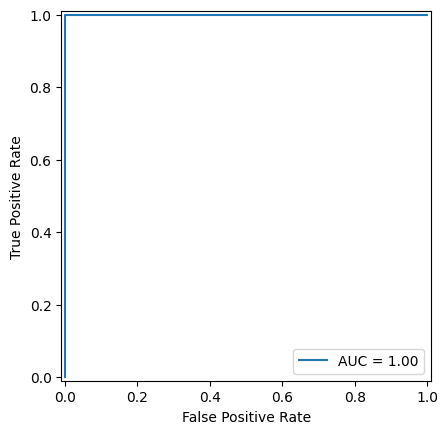

In [123]:
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=test_score).plot()

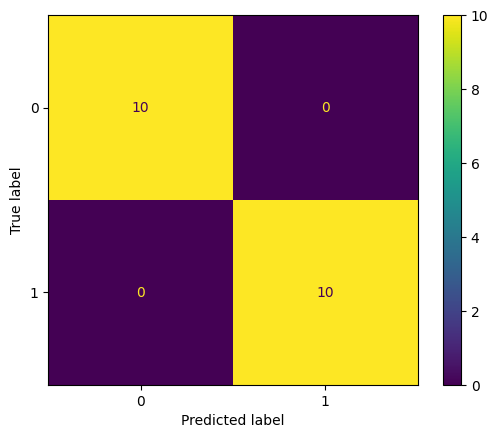

In [124]:
conf_matrix = ConfusionMatrixDisplay.from_predictions(targets, preds).confusion_matrix

In [ ]:
total_samples = len(samples_list)
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size
print(f"Total samples: {total_samples}, train_size: {train_size}, val_size: {val_size}, test_size: {test_size}")

In [ ]:
train_samples = samples_list[:train_size]
val_samples = samples_list[train_size:train_size+val_size]
test_samples = samples_list[train_size+val_size:]
print(f"Train samples: {train_samples}\n\nval samples: {val_samples}\n\ntest samples: {test_samples}")

In [ ]:
for sample in test_data:
    for fov in sample:
        score = fov[1]
        print(score)